#**Subtask B - Conspiracy Category Classification**

#**Gruppo: Tris di Token**
Componenti: Barca Antonio, Bongiorno Rosario,
Giambanco Alessandro

#Librerie

In [1]:
!pip install emoji
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import nltk
import re
from sklearn.metrics import f1_score
import torch
from tqdm import tqdm
import emoji
from torch import nn
from torch.optim import Adam
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

#Dati iniziali

In [3]:
drive.mount('/content/gdrive')
root = "/content/gdrive/MyDrive/Tris di token/dataset/"

df_start = pd.read_csv(root+"subtaskB_train.csv")

Mounted at /content/gdrive


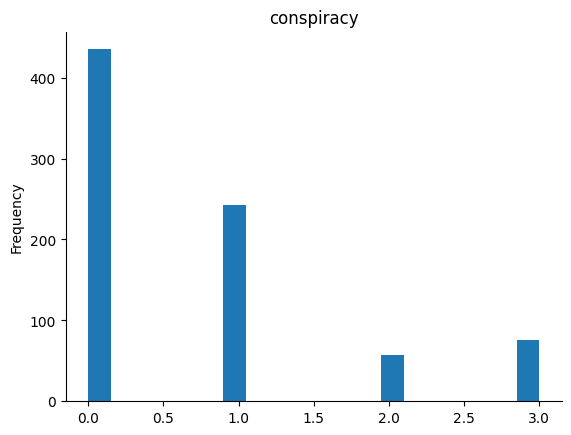

In [4]:
from matplotlib import pyplot as plt
df_start['conspiracy'].plot(kind='hist', bins=20, title='conspiracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

#Data Augmentation

Avendo notato uno sbilanciamento verso alcune categorie  nel dataset fornito da kaggle per il task B abbiamo aumentato il dataset attraverso  due dataset cospiratori:   
* Per la classe Russia, abbiamo usato il dataset "2022 Russia Ukraine War" https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war, .  
* Per la classe Flat Earth, abbiamo usato il dataset "Flat Earth on Twitter" https://www.kaggle.com/datasets/gpreda/flat-earth-on-twitter  


 Dopo averli tradotti in italiano e rielaborati abbiamo estratto da esso i dati più simili a quelli del dataset originale e li abbiamo inseriti al fine di ottenere un miglior bilanciamento delle categorie e quindi evitare overfitting verso le classi più sbilanciate.

Dataset aggiunto alla classe Russia:

In [ ]:
df_russia_augmented=pd.read_csv(root+"russia_war.csv")
df_russia_augmented

,self_text,conspiracy
0,"Alcuni di loro hanno solo bisogno dei bagni, d...",2
1,Sono stato un repubblicano moderato per gran p...,2
2,"Avrebbe dovuto succedere 9 mesi fa, ma sono co...",2
3,Non interrompere mai il tuo nemico quando sta ...,2
4,semplicemente lasciarli cadere sulla Russia do...,2
...,...,...
373,Non funzionano se l’obiettivo delle sanzioni è...,2
374,"sì, poiché gli aiuti dell’UE stanno aumentando...",2
375,La Striscia di Gaza è a 4. Il Niger a circa 6,2
376,La legge sull'autorizzazione alla difesa è sta...,2


Dataset aggiunto alla classe Flat Earth:

In [ ]:
df_flatearth_augmented=pd.read_csv(root+"flat_earth.csv")
df_flatearth_augmented

,text,conspiracy
0,Non hai solo i classici Flerf ma LA lezione Fl...,3
1,Voglio ancora dire...Kyrie Irving è un IDIOTA....,3
2,Solo il modello Flat Earth può calcolare l'esa...,3
3,Il modello Flat Earth calcola altri 2 indici d...,3
4,"…ma non possono, perché non puoi distruggere c...",3
...,...,...
284,Beh... sono davvero un buon amico con lui... v...,3
285,I credenti della Terra Piatta hanno i piedi pi...,3
286,O si!!!!! questo sarà sicuramente il mio pross...,3
287,"#QAnonCult, l'asteroide che passerà vicino all...",3


Caricamento dei dataset aumentati:

In [5]:
df_train = pd.read_csv(root+"subtaskB_train_30augmentation.csv")
df_val = pd.read_csv(root+"subtaskB_val_30augmentation.csv")

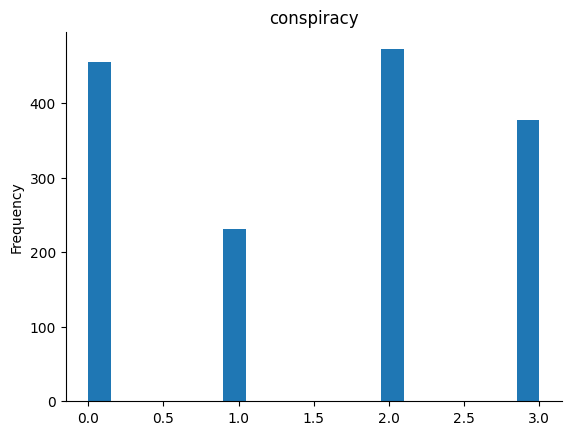

In [6]:
from matplotlib import pyplot as plt
df_train['conspiracy'].plot(kind='hist', bins=20, title='conspiracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

Dal precedente istogramma  si evince che adesso il dataset risulta più bilanciato in tutte le classi, tranne per la qanon dove non abbiamo trovato un dataset compatibile.

#Pre-processing

Dopo aver esaminato il dataset, per il pre-processing abbiamo deciso di rimuovere tutti i testi tra parentesi, analizzare tutte le emoji presenti nel dataset per capire quali di essi contenevano informazioni rilevanti al fine della classificazione.  

In [7]:
def rimuovi_parentesi(testo): #Funzione per rimuovere i testi tra parentesi tonde all'interno del dataset
    pattern_parentesi = re.compile(r'\([^)]*\)')
    testo_senza_parentesi = pattern_parentesi.sub('', testo)
    return testo_senza_parentesi

ANALISI EMOJI  
A seguito alcune funzioni:

In [8]:

def estrai_tra_due_punti(frase): #Funzione per trovare le emoji demojizzate
    risultati = re.findall(r'(:\S*?:)', frase) # Espressione regolare per catturare il testo tra due "due punti", compresi anch'essi, senza spazi all'interno
    return risultati

def trova_emoji(testo):
    emoji_scritta = emoji.demojize(testo,delimiters=(" :",": "), language='it')
    emoji_trovate = estrai_tra_due_punti(emoji_scritta)
    return emoji_trovate

def analisi_emoji(df):

  # Aggiungi una colonna con le emoji presenti in ciascun commento
  df['emojis'] = df['comment_text'].apply(trova_emoji)

    # Creazione tabella di comparazione
  db_emoji = pd.DataFrame()

  # Creazione della colonna 'Emoji' con tutte le emoji uniche
  db_emoji['Emoji'] = pd.Series(df['emojis'].explode().unique())

  # Conteggio delle emoji in contesto 'Covid'
  db_emoji['Covid'] = db_emoji['Emoji'].apply(lambda x: df[df['conspiracy'] == 0]['emojis'].apply(lambda y: x in y).sum())

  # Conteggio delle emoji in contesto 'Qanon'
  db_emoji['Qanon'] = db_emoji['Emoji'].apply(lambda x: df[df['conspiracy'] == 1]['emojis'].apply(lambda y: x in y).sum())

  # Conteggio delle emoji in contesto 'Russia'
  db_emoji['Russia'] = db_emoji['Emoji'].apply(lambda x: df[df['conspiracy'] == 2]['emojis'].apply(lambda y: x in y).sum())

  # Conteggio delle emoji in contesto 'Flat-Earth'
  db_emoji['Terra Piatta'] = db_emoji['Emoji'].apply(lambda x: df[df['conspiracy'] == 3]['emojis'].apply(lambda y: x in y).sum())


  db_emoji['Total'] = db_emoji['Covid'] + db_emoji['Qanon'] + db_emoji['Russia'] + db_emoji['Terra Piatta']

  # Ordina il DataFrame in base alla colonna 'Total' in senso decrescente
  db_emoji = db_emoji.sort_values(by='Total', ascending=False)


  categories = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']

  db_emoji["rilevanti"]=False

  for category in categories:
    # distribuzione emoji rispetto le categorie in percentuale
    db_emoji[category] = db_emoji[category] / db_emoji['Total'] * 100

  db_emoji = aggiungi_colonna_rilevanti(db_emoji)

  return  db_emoji

def aggiungi_colonna_rilevanti(dataset):

    df = dataset.copy()

    # Inizializza una lista per la colonna 'rilevanti'
    rilevanti = []

    # Scorre tutte le righe del dataset
    for index, row in df.iterrows():
        # Se un emoji è presente in una categoria almeno il 40% e
        # almeno 8 volte in tutto il dataset diventa rilevante
        if any(value > 40 for value in row[1:5]) and row['Total'] > 8:
            rilevanti.append(True)
        else:
            rilevanti.append(False)

    # Aggiunge la colonna 'rilevanti' al dataset
    df['rilevanti'] = rilevanti

    return df

def elimina_emoji(text,db_emoji):

  for parola in text.split():

    if parola in db_emoji['Emoji'].tolist() :

      if db_emoji.query(f"Emoji=='{parola}'")['rilevanti'].tolist()[0]==False:
          text=text.replace(parola, " ")

  return text

Creazione delle tabella delle emoji

In [11]:
db_emoji=analisi_emoji(df_train)

display(db_emoji.head(15))

,Emoji,Covid,Qanon,Russia,Terra Piatta,Total,rilevanti
2,:bandiera_italia:,85.517241,13.103448,1.379310,0.00,145,True
12,:punto_esclamativo_rosso:,47.058824,47.058824,5.882353,0.00,51,True
17,:libri:,100.000000,0.000000,0.000000,0.00,33,True
16,:simbolo_di_avviso:,96.153846,0.000000,3.846154,0.00,26,True
21,:grafico_a_barre:,100.000000,0.000000,0.000000,0.00,21,True
10,:pagina:,100.000000,0.000000,0.000000,0.00,20,True
4,:faccina_con_lacrime_di_gioia:,18.750000,31.250000,18.750000,31.25,16,False
38,:uomo_esasperato:,35.714286,57.142857,7.142857,0.00,14,True
46,:quotidiano_arrotolato:,100.000000,0.000000,0.000000,0.00,13,True
5,:ridere_a_crepapelle:,8.333333,41.666667,25.000000,25.00,12,True


Dopo aver esaminato la tabella delle emoji abbiamo constatato che
 alcune emoji risultano abbastanza significative per la classificazione in quanto esse compaiono in maniera predominante in una o più classi rispetto alle altre; pertanto abbiamo deciso di eliminare tutte quelle emoji che non risultavano rilevanti dal dataset lasciando esclusivamente quelle che lo sono.    



Pre-processing per train e validation

In [ ]:
def preprocessing(df, db_emoji):

  df['comment_text'] = df['comment_text'].apply(rimuovi_parentesi)
  df['comment_text'] = df['comment_text'].str.replace('\n', ' ')

  df['comment_text'] = df['comment_text'].apply(lambda x:emoji.demojize(x,delimiters=(" :",": "),language='it'))

  df['comment_text'] = df['comment_text'].apply(lambda x:elimina_emoji(x,db_emoji))

  return df

In [ ]:
df_train=preprocessing(df_train, db_emoji)
df_val=preprocessing(df_val, db_emoji)

DF_TRAIN

In [ ]:
display(df_train)

,Id,comment_text,topic,conspiracy,emojis
0,1409,"è più facile essere terrapiattisti, non è nece...",Terra Piatta,3,[]
1,202,**Ritengo questo audio piuttosto importante**:...,Covid,0,"[:teschio:, :teschio:, :bandiera_italia:]"
2,461,Altri studi condotti dall'università sparo caz...,Covid,0,"[:bicipite_carnagione_chiara:, :bicipite_carna..."
3,561,Nel video tutto ruota attorno al sistema solar...,Terra Piatta,3,[]
4,844,Perché la vera ragione era che lo sviluppo del...,Russia,2,[]
...,...,...,...,...,...
1530,45,Dinesh su come 2000 Mules dimostra che Trump h...,Qanon,1,[:triangolo_rosso_con_punta_verso_il_basso:]
1531,1209,Voi gente della terra piatta là fuori. Ciò dim...,Terra Piatta,3,[:america:]
1532,1029,La Polonia dovrebbe chiedere alla Lituania se ...,Russia,2,[]
1533,1098,*Nel frattempo un topo legato ad un gioco di r...,Russia,2,[]


DF_VAL

In [ ]:
display(df_val)

,Id,comment_text,topic,conspiracy
0,808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,Covid,0
1,942,Puoi dire che sta dicendo la verità dalle onda...,Russia,2
2,626,"Ex ministro Castelli ""sono vittima del veleno ...",Covid,0
3,518,Inizia a smontarsi anche la farsa del 6 Gennai...,Qanon,1
4,1435,Jake The Asshole e Jeranism si estorcono a vic...,Terra Piatta,3
...,...,...,...,...
291,66,L'ESPOSIZIONE STA DANDO I SUOI FRUTTI \r \r Or...,Qanon,1
292,41,Continuano a dirti che il covid è stato trasme...,Covid,0
293,355,Perché per Zelensky è così complicato trovare ...,Russia,2
294,772,La visita di Draghi alla Casa Bianca è stata p...,Qanon,1


#Creazione Dataset

Il modello xml-roberta consente la tokenizazzione delle emoji, quindi nel caso in cui usiamo questo modello convertiamo le stringhe delle emoji nei loro rispettivi caratteri esadecimali

In [ ]:
roberta=False
if roberta  :
  df_train['comment_text'] = df_train['comment_text'].apply(lambda x:emoji.emojize(x, language='it'))
  df_val['comment_text'] = df_val['comment_text'].apply(lambda x:emoji.emojize(x, language='it'))


In [ ]:
x_train,y_train=df_train['comment_text'], df_train['conspiracy']
x_val,y_val=df_val['comment_text'], df_val['conspiracy']

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, flag, stopwords,tokenizer):

        if stopwords:

            tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence]))    # ogni token è separato dall'altro con uno spazio


        self.texts = [tokenizer(text, add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 512, truncation=True)
                    for text in text_clean]

        if flag:
          self.labels = [torch.tensor(label) for label in y]


    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.texts)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)

        batch_labels = -1
        if hasattr(self, 'labels'):
            batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Iperparametri

In [ ]:
hyperparameters = {
    "epochs": 30,
    "learning_rate": 1e-5,
    "batch_size": 8,
    "dropout": 0.5,
    "stopwords": True,
    "patience": 5,
    "min_delta": 0.0001,
    #"language_model": "xlm-roberta-base",
    #"language_model":"dbmdz/bert-base-italian-cased",
    "language_model":"bert-base-multilingual-cased"
}

tokenizzazione dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['language_model'])

train_dataset = Dataset(x_train, y_train,True, hyperparameters["stopwords"],tokenizer)
val_dataset = Dataset(x_val, y_val,True, hyperparameters["stopwords"],tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing ... : 100%|██████████| 296/296 [00:03<00:00, 88.90it/s]


###Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience, min_delta):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramento della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione
        self.best_model = False                 # flag che indica il modello con validation loss migliore

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            self.best_model = False                                         # impostiamo best model a False
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")

        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
            self.best_model = True                                          # come nuova loss ottimale,
            self.counter = 0                                                # impostiamo best model a True
                                                                            # e azzeriamo il contatore di pazienza

# Creazione Train e Test Loop

In fase di train abbiamo utilizzato gli input ids e attention mask presi da ogni batch creato precedentemente per fare generare al modello gli output  (logits)  
I modelli utilizzati come backbone sono:

* "dbmdz/bert-base-italian-cased"  
* "bert-base-multilingual-cased"  
* "xlm-roberta-base"

Come funzione di attivazione abbiamo scelto la softmax in quanto si tratta di classificazione multiclasse e come metriche abbiamo scelto di utilizzare l'accuracy e l'f1score.

In [ ]:
def train_loop(model, dataloader, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0
    f1=0

    for batch_texts, batch_labels in tqdm(dataloader,desc='Training loop'):

        optimizer.zero_grad()

        input_id_texts = batch_texts['input_ids'].squeeze(1).to(device)
        mask_texts =batch_texts['attention_mask'].to(device)
        batch_labels = batch_labels.to(device)

        output = model(input_id_texts, attention_mask=mask_texts)



        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        f1 += f1_score(batch_labels.cpu().numpy(),softmax(output).argmax(dim=1).cpu().numpy(), average='weighted')

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc, f1/ len(dataloader)

Per il test loop il codice è uguale escludendo l'aggiornamento dei pesi del modello.

In [ ]:
def test_loop(model, dataloader, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0
    f1=0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader,desc="Val loop"):


            input_id_texts =batch_texts['input_ids'].squeeze(1).to(device)
            mask_texts = batch_texts['attention_mask'].to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_id_texts, attention_mask=mask_texts)



            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()
            # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()


            f1 += f1_score(batch_labels.cpu().numpy(),softmax(output).argmax(dim=1).cpu().numpy(), average='weighted')

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss / len(dataloader), epoch_acc,f1/ len(dataloader)

##Train Test

Utilizziamo il DataLoader per caricare i vari batch di train e validation che vengono passati al train e test loop.  
Ad ogni epoca valutiamo i valori di validation loss per stabilire un eventuale Early stopping, al fine di evitare l'overfitting e migliorare la generalizzazione del modello, salvando il modello con la migliore configurazione dei pesi.

In [ ]:
def train_test(model, epochs, optimizer, device, train_data,
               batch_size, language_model, train_loss_fn,
               early_stopping=None, val_data=None, scheduler=None):

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,drop_last=True)


    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []


    train_acc = []
    validation_acc = []

    f1_scores_train=[]
    f1_scores_val=[]


    tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping

    for epoch in range(1,epochs+1):

            print("Epoca "+ str(epoch))

            epoch_train_loss,epoch_train_acc,f1_train = train_loop(model, train_dataloader, train_loss_fn, optimizer, device)
            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc/len(train_data))
            f1_scores_train.append(f1_train)

            # validation se è presente la callback di early stopping
            if early_stopping != None:

                    epoch_validate_loss,epoch_validate_acc,f1_val = test_loop(model, val_dataloader,train_loss_fn, device)
                    validation_loss.append(epoch_validate_loss)
                    validation_acc.append(epoch_validate_acc/len(val_data))
                    f1_scores_val.append(f1_val)

            val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
            val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '

            print(f"Train loss: {epoch_train_loss:6.4f} {val_loss_str}")
            print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}")
            print(f"f1_train: {f1_train:6.4f} f1_val: {f1_val:6.4f}")


            # early stopping
            if early_stopping != None:
                    early_stopping(epoch_validate_loss)
                    # salvataggio modello
                    if early_stopping.best_model:
                      torch.save(model, f'model_subtaskB.pt')
                      print('Saved model!')
                    if early_stopping.early_stop:
                        break

    return train_loss, validation_loss, train_acc, validation_acc,f1_scores_train,f1_scores_val

### Classificatore Multiclasse

Come layer finali della nostra rete di classificazione binaria abbiamo scelto due strati lineari, uno di Batch Normalization, e uno di Dropout per migliorare la generalizzazione della rete.  
Passiamo come input a questi layer l'embedding del token cls rappresentativo della classe, ottenuto dal modello di backbone.

In [ ]:
class Classifier(nn.Module):

    def __init__(self,model_name,dropout):
        super(Classifier, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name,config=config)
        self.classifier = nn.Sequential(
                  nn.Linear(768,384),
                  nn.BatchNorm1d(384),
                  nn.Dropout(dropout),
                  nn.ReLU(),
                  nn.Linear(384, 4))

    def forward(self,input_txt,attention_mask):

        output = self.lm_model(input_txt, attention_mask=attention_mask).last_hidden_state
        return self.classifier(output[:,0,:]) #(batch_size, sequence_length, hidden_size)
                                              #vettorizzazione del token cls,input rete densa



Come funzione di loss abbiamo usato la  cross entropy al cui interno è contenuta la LogSoftmax pertanto passiamo direttamente i logits della rete alla funzione

In [ ]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = Classifier(hyperparameters["language_model"],
                    hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion= nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


Using cpu device


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Classifier(
  (lm_model): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

Procediamo con l'addestramento

In [ ]:
# Routine di addestramento
train_loss, validation_loss, train_acc, validation_acc,f1_scores_train,f1_scores_val = train_test(model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                early_stopping,
                                                val_dataset)

##Plot

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

plt.plot(f1_scores_train, label='f1 training')
plt.plot(f1_scores_val, label='f1 validtion')
plt.legend(loc='lower right')
plt.ylim(0.3,1)
plt.show()

plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

##Preparazione dataset per submission

In [ ]:
df_test=pd.read_csv(root+"subtaskB_test.csv")
df_test=preprocessing(df_test, db_emoji)
df_test['comment_text']=df_test['comment_text'].apply(lambda x:emoji.emojize(x, language='it'))
x_test=df_test['comment_text']

tokenizzazione dataset (label non presenti implica il flag a False)

In [ ]:
test_dataset= Dataset(x_test, None,False, hyperparameters["stopwords"],tokenizer)

Inferenza sui batch e valutazione degli output

In [ ]:
def get_text_predictions(model, loader):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = model.to(device)

    results_predictions = []

    with torch.no_grad():
        model.eval()
        for data_input, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)

            output = model(input_ids, attention_mask)

            softmax = nn.LogSoftmax(dim=1)
            output = softmax(output).argmax(dim=1)

            results_predictions.append(output)

    return torch.cat(results_predictions).cpu().detach().numpy()

Caricamento del modello con configurazione di pesi migliore sulla base della validation loss ottenuta

In [ ]:
model = torch.load("model_subtaskB.pt")

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

test_submission = pd.read_csv(root+"sample_submission_B.csv")

test_submission = test_submission.drop(test_submission.tail(162).index)

In [ ]:
test_submission['Expected'] = get_text_predictions(model, test_dataloader)

test_submission.to_csv("submission.csv", index=False) # salvataggio in formato csv

#Analisi Modelli Backbone

In questa sezione vengono approfonditi al variare degli iperparametri i modelli usati come backbone ovvero:


*   Bert-base-multilingual-cased
*   Dbmdz/bert-base-italian-cased
*   Xlm-roberta-base

gli iperparametri che abbiamo testato sono i seguenti :

*   Epoche [30,50]
*   Learning rate [1e-5,1e-6]
*   Batch size [8,16]
*   Pazienza [5,10]

Analizzeremo in ogni sezione l'andamento della loss function,accuracy ed f1 score al variare delle epoche

##Bert-base-multilingual-cased

Iniziamo caricando i plot  che mostrano i risultati ottenuti in fase di addestramento e valutazione del modello

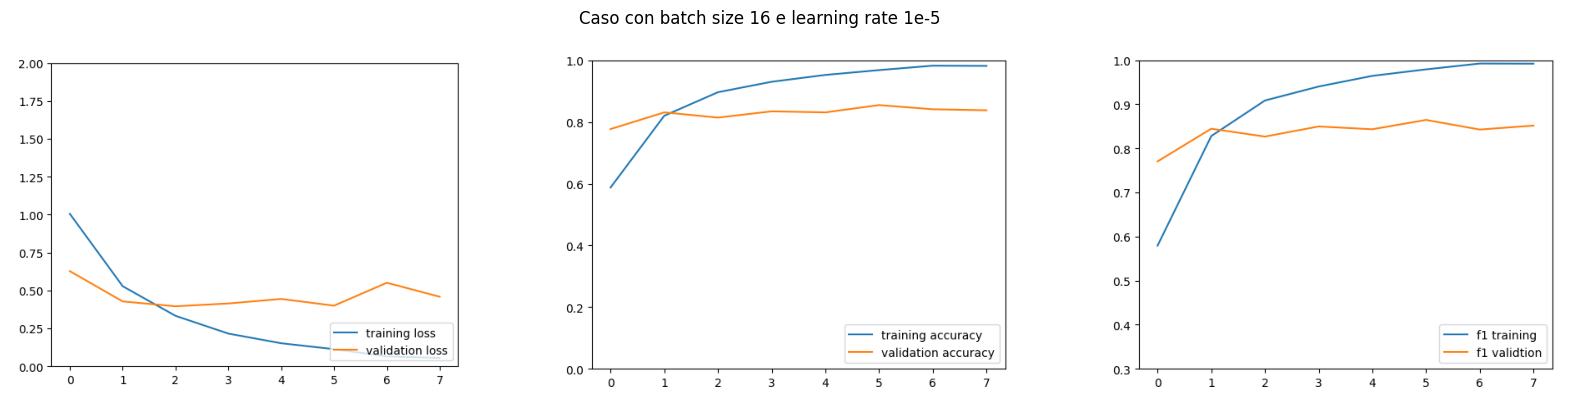

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


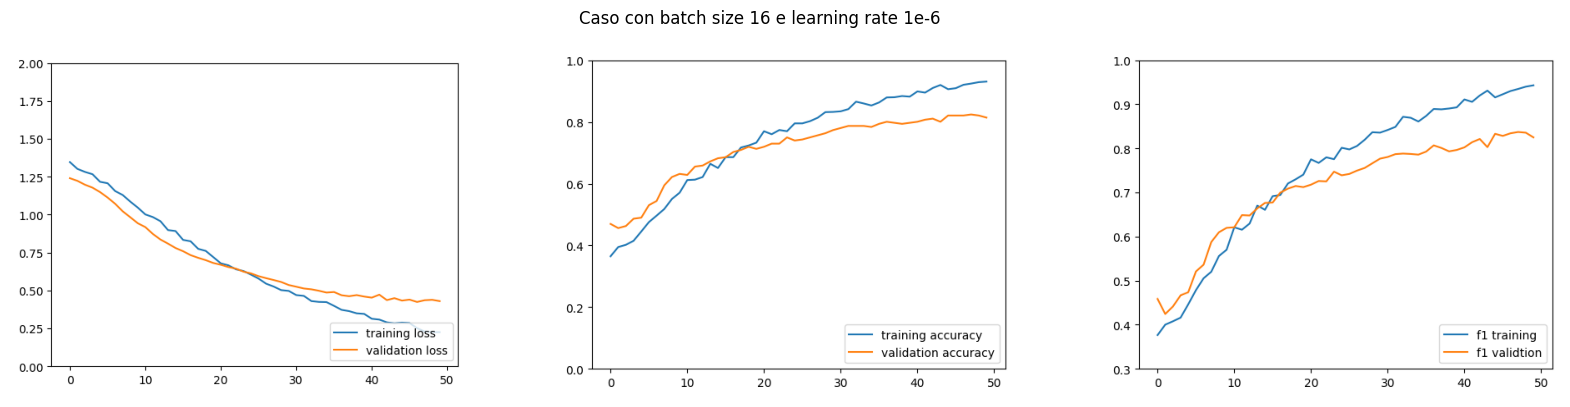

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


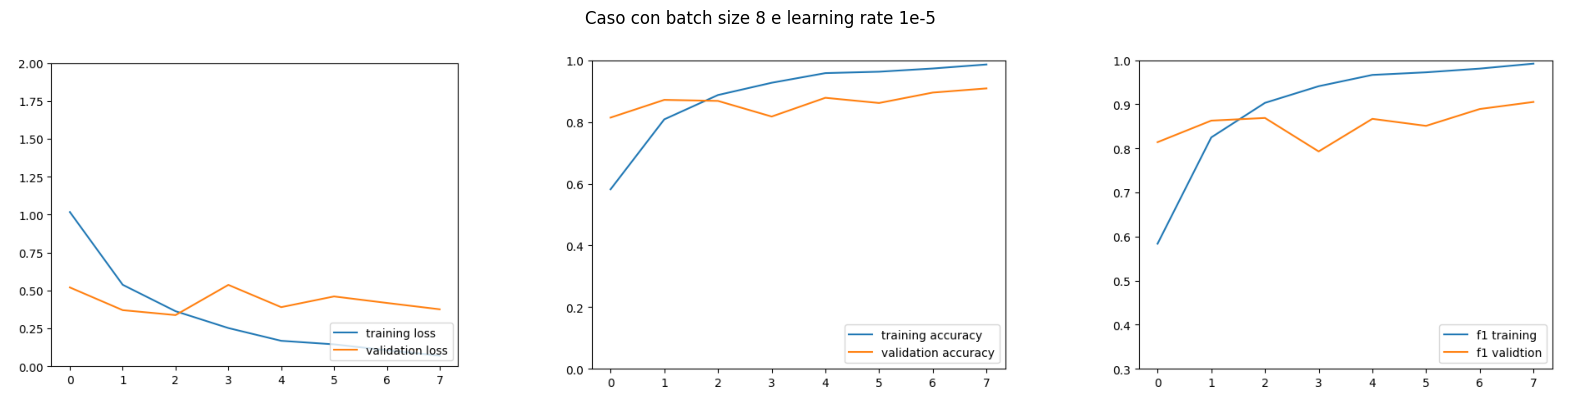

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


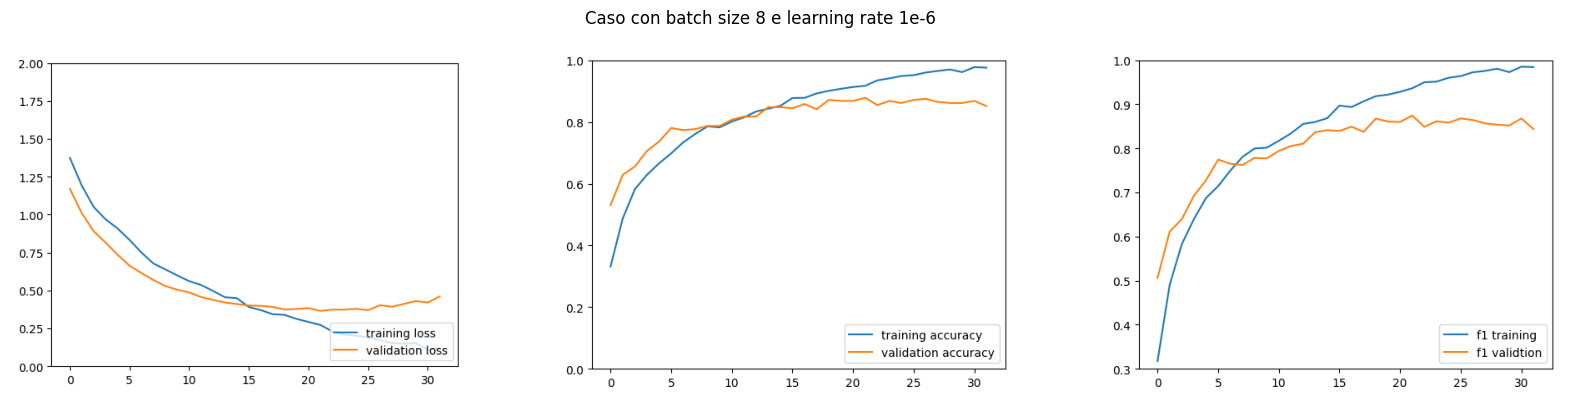

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Bert_Multilingua_Plot/Subtask B'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['batch size 16 e learning rate 1e-5', 'batch size 16 e learning rate 1e-6', 'batch size 8 e learning rate 1e-5', 'batch size 8 e learning rate 1e-6']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')



Risultati dell'addestramento alla migliore epoca:

In [ ]:
bert_multilingua_risultati=pd.read_csv(root+"bert_multilingua_risultatiB.csv",delimiter=";")
bert_multilingua_risultati

,Iperparametri,loss,accuracy,f1
0,bs: 16 lr:1e-5,0.3960,0.8142,0.8268
1,bs: 8 lr:1e-5,0.3379,0.8682,0.8691
2,bs: 16 lr:1e-6,0.4244,0.8209,0.8343
3,bs: 8 lr:1e-6,0.3658,0.8784,0.8747


Il modello usato  come backbone in questo caso è bert base multilingua preaddestrato, esso ha ottenuto in generale dei buoni risultati su entrambi i task e come gli altri tende a discriminare meglio nel task B .  
Per il task B si confermano come migliori   iperparametri batch size :8 e learning rate :1e-6 sebbene comportino un addestramento molto lungo, 22 epoche con earlystopping a pazienza 10, soprattutto a causa del learning rate più basso;
avendo  ottenuto valori più ragionevoli   il modello sembra aver appreso
a discriminare  maggiormente i dati rispetto le 4 label( ovvero le categorie di testi cospiratori) difatti i valori di validation loss ed f1 score riferito al validation set sono rispettivamente  0.3658 ed 0.8747, sicuramente valori più confortevoli rispetto il task precedente sebbene la loss si mantenga comunque non troppo bassa.


##Roberta Model

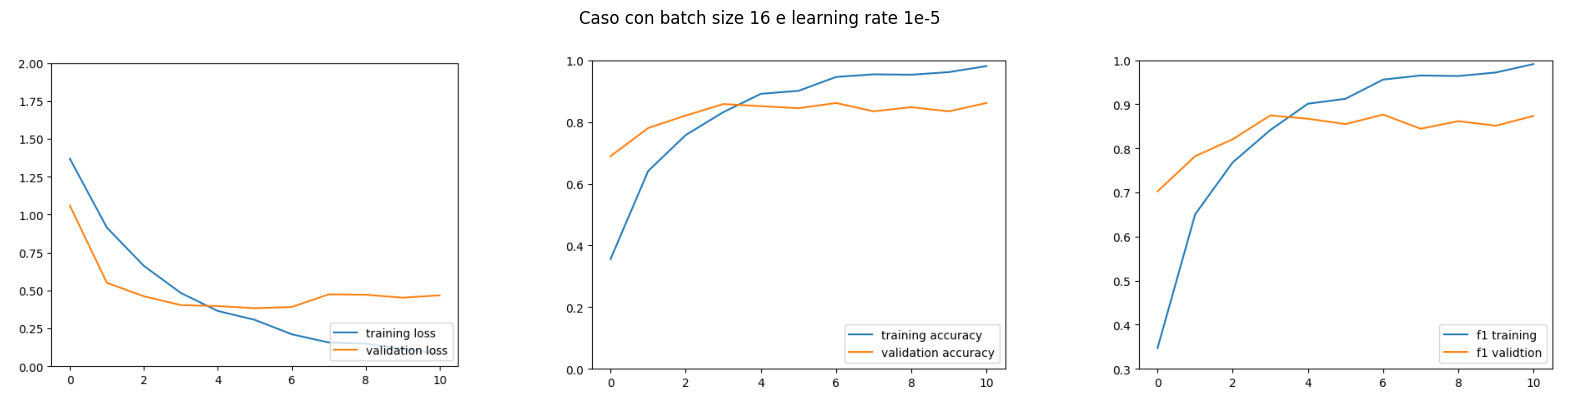

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


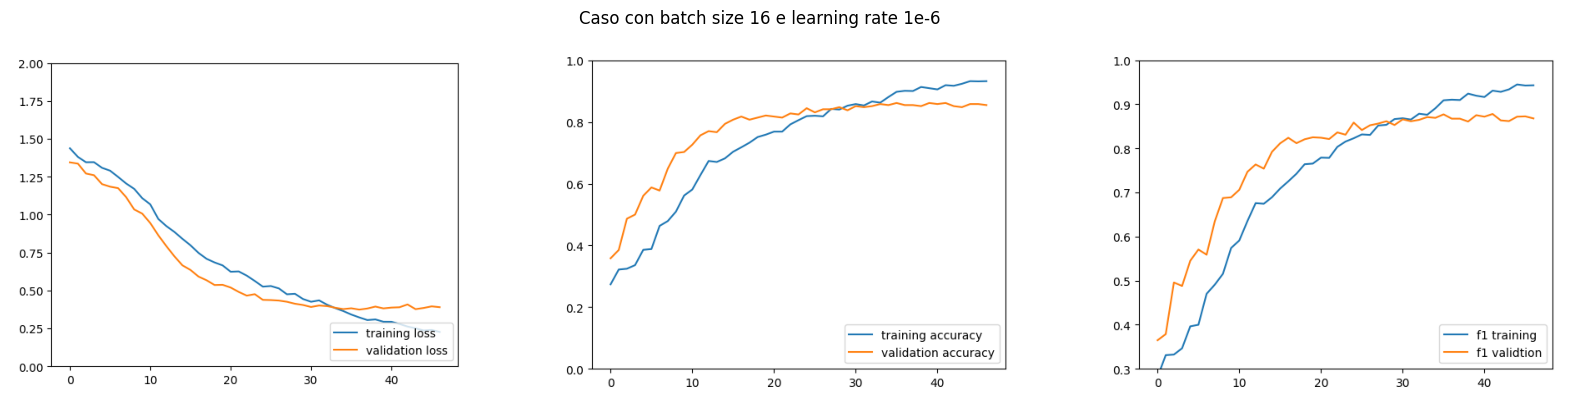

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


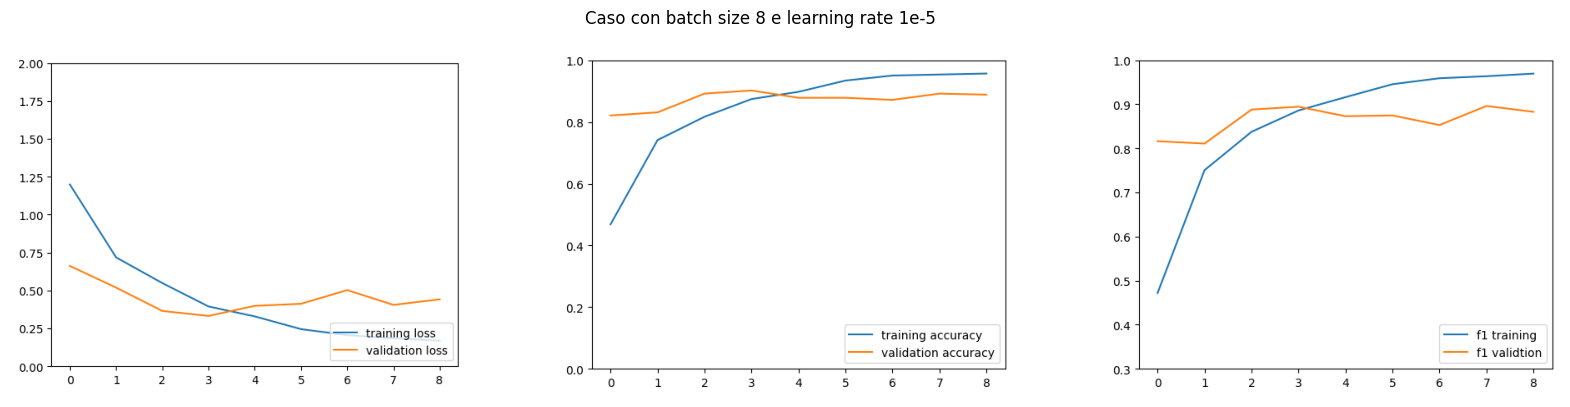

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


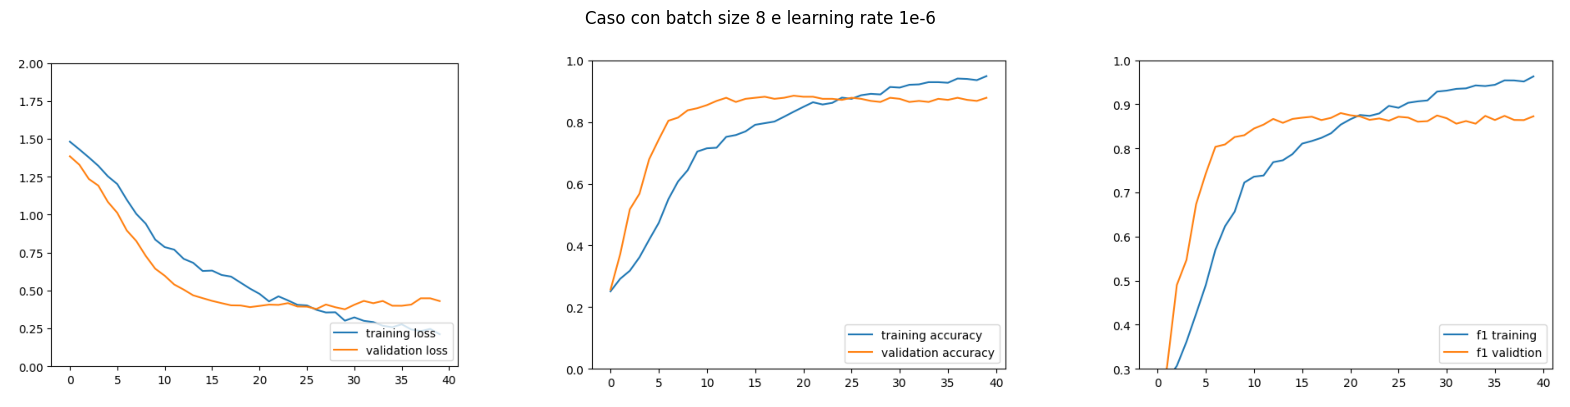

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Roberta_Plot/Subtask B'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['batch size 16 e learning rate 1e-5', 'batch size 16 e learning rate 1e-6', 'batch size 8 e learning rate 1e-5', 'batch size 8 e learning rate 1e-6']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

Risultati dell'addestramento alla migliore epoca:

In [ ]:
roberta_risultati=pd.read_csv(root+"roberta_risultatiB.csv",delimiter=";")
roberta_risultati

,Iperparametri,loss,accuracy,f1
0,bs: 16 lr:1e-5,0.3832,0.8446,0.8552
1,bs: 8 lr:1e-5,0.3324,0.9020,0.8946
2,bs: 16 lr:1e-6,0.3741,0.8547,0.8675
3,bs: 8 lr:1e-6,0.3781,0.8750,0.8699


Anche in questo caso le performance di xlm-roberta per il subtask B risultano miglior in termini di accuracy ed f1 score rispetto agli altri due modelli utilizzati.  
Lasciando infatti il dataset con le emoji non tradotte riusciamo ad ottenere l'addestramento migliore sin dalle prime epoche; in particolare, avendo una batch size pari a 8 e learning rate a 1e-5, possiamo vedere che gia alla terza epoca abbiamo ottenuto la validation loss minore.

##Italian Bert Model

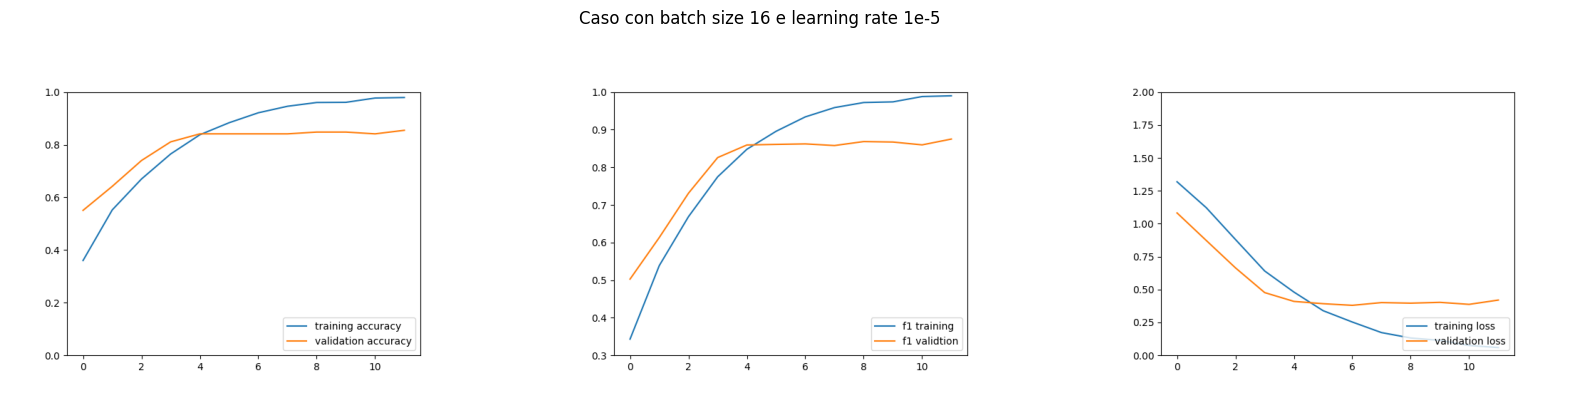

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


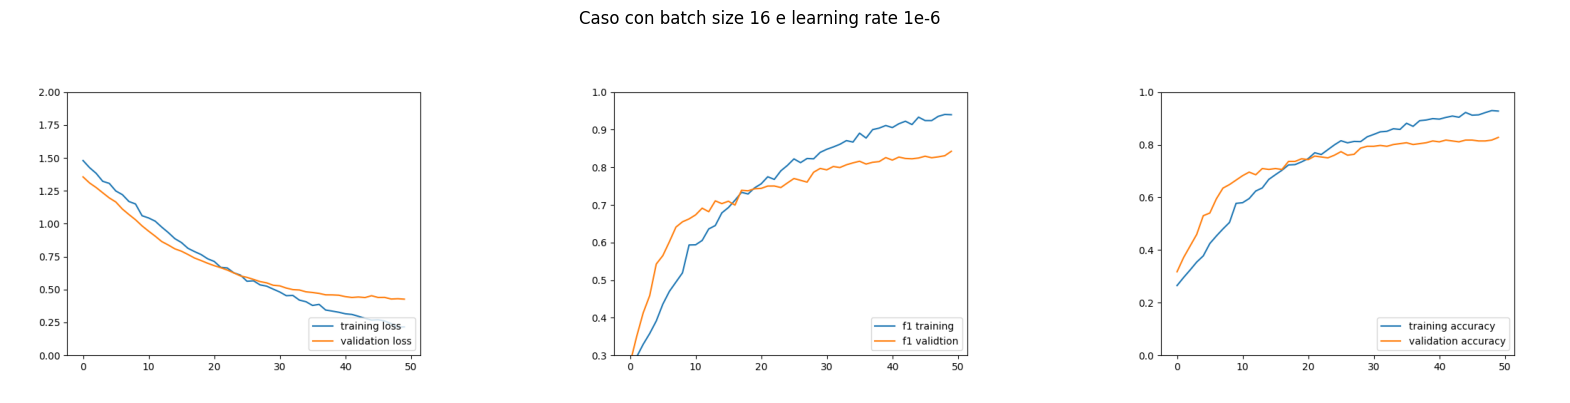

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


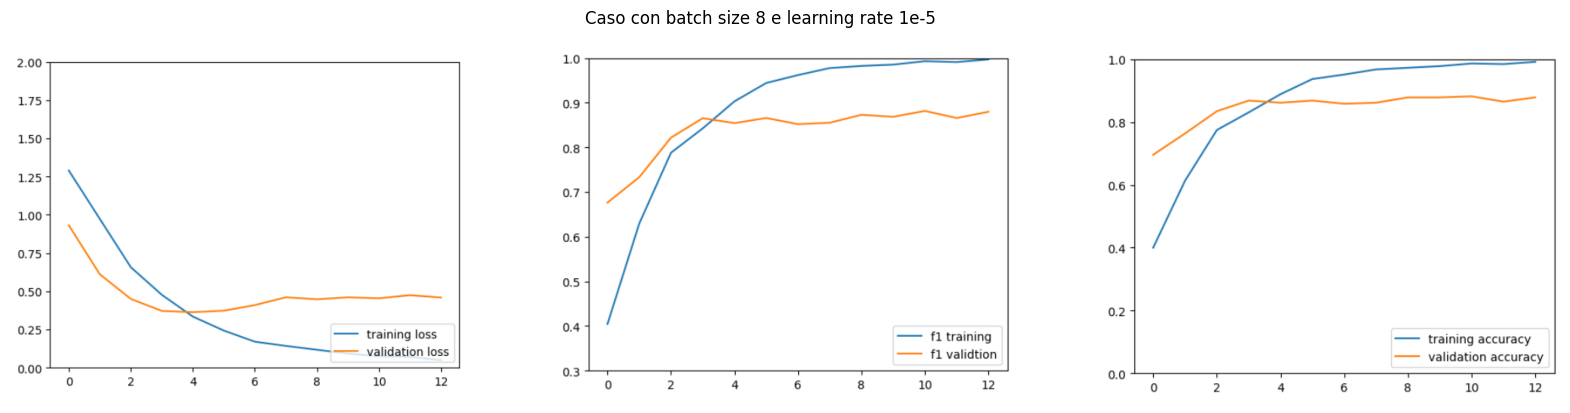

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


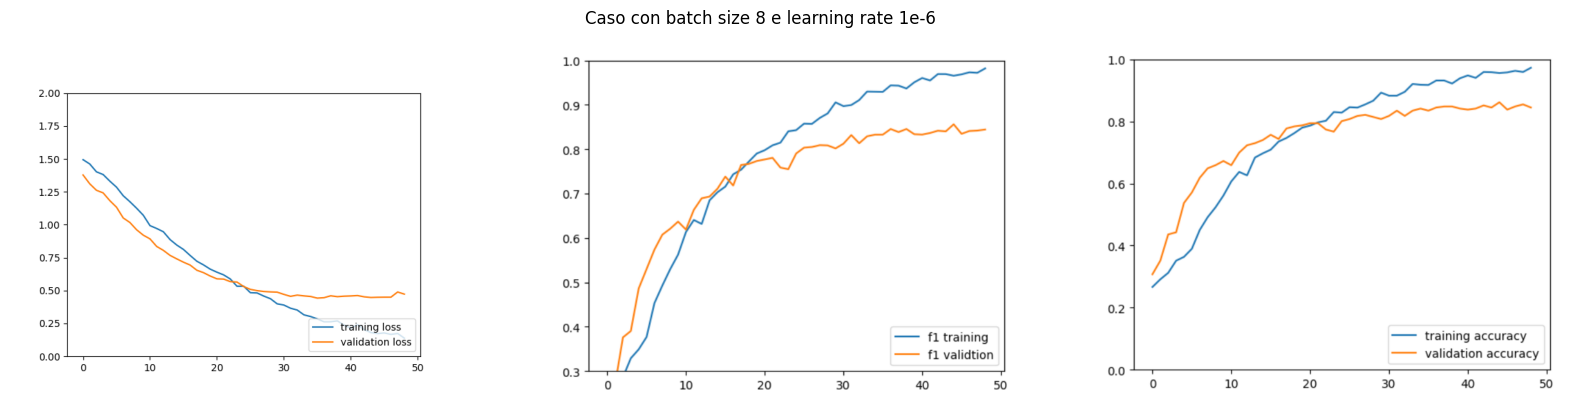

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Italian_Bert_Plot/Subtask B'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['batch size 16 e learning rate 1e-5', 'batch size 16 e learning rate 1e-6', 'batch size 8 e learning rate 1e-5', 'batch size 8 e learning rate 1e-6']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

Risultati dell'addestramento alla migliore epoca:

In [ ]:
italian_bert_risultati=pd.read_csv(root+"italian_bert_risultatiB.csv",delimiter=";")
italian_bert_risultati

,Iperparametri,loss,accuracy,f1
0,bs: 16 lr:1e-5,0.3801,0.8412,0.8621
1,bs: 8 lr:1e-5,0.3636,0.8615,0.8545
2,bs: 16 lr:1e-6,0.4302,0.8176,0.8307
3,bs: 8 lr:1e-6,0.4424,0.8345,0.8329


Da una analisi dei risultati possiamo notare che tutte e quattro le combinazioni di iperparametri con questo modello ottengono risultati buoni e comparabili, ma la migliore come anche per i modelli xml-roberta e Multilingual-Bert è la combinazione di batch size: 8 e learning rate 1e-5 dove otteniamo una validation loss di 0.3636, una validation accuracy di 0.8615 e un f1score di 0.8545, analizzando i grafici notiamo una decrescita della loss fino all'epoca 3 e successivamente una piccola crescita, infatti il modello dopo 5 epoche di pazienza si è stoppato grazie all'early stopping.

#Ulteriore Analisi di Data Augmentation

Infine, come ulteriore analisi, abbiamo pensato di applicare la stessa data augmentation del subtask A, e cioè la doppia traduzione, questa volta solamente per le classi più sbilanciate cioè Russia e Terra Piatta.
Per la creazione del validation set abbiamo effettuato lo split del dataset prima di effettuare le traduzioni cosi da evitare che il modello si addestri su testi che sono molto simili a quelli presenti nel validation set e quindi rendere i risultati poco attendibili.


In [14]:
df_train_translate = pd.read_csv(root+"subtaskB_train_traslate.csv")

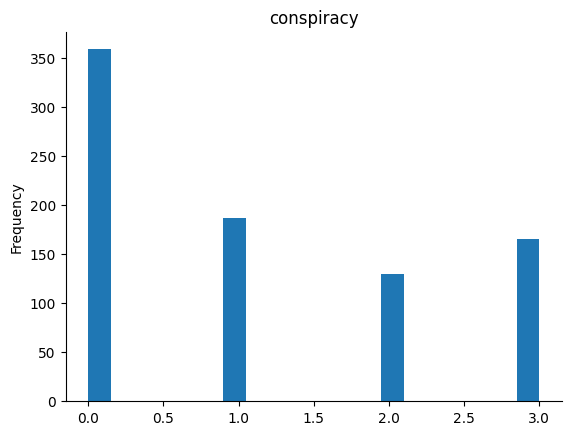

In [15]:
df_train_translate['conspiracy'].plot(kind='hist', bins=20, title='conspiracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

Quindi abbiamo riaddestrato i tre modelli di backbone con i migliori iperparametri ottenuti precedentemente cioè batch size 8 e learning rate 1e-5 ottenendo i seguenti risulati:


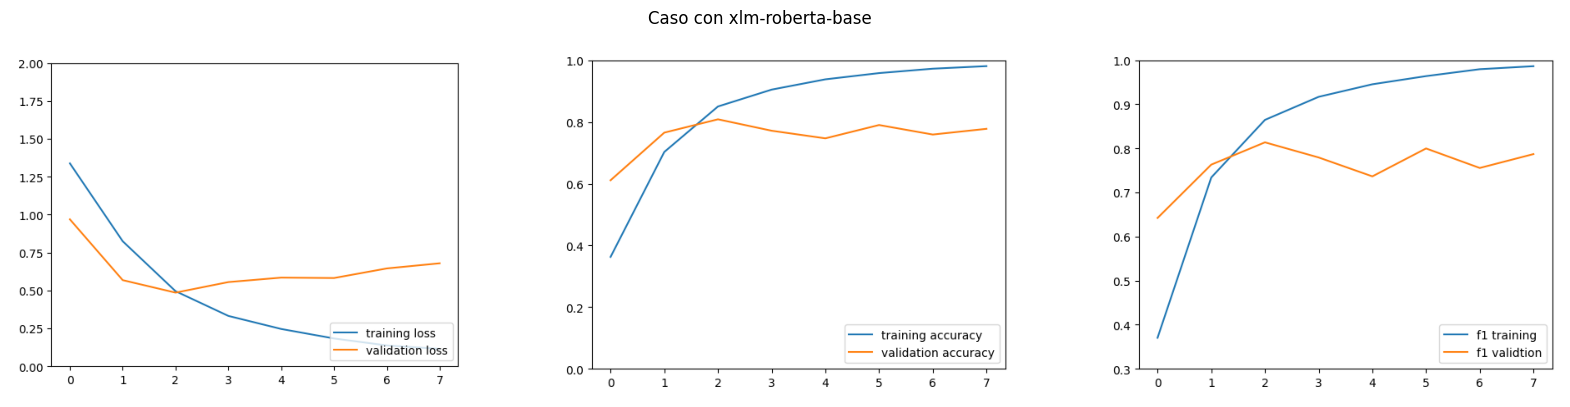

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


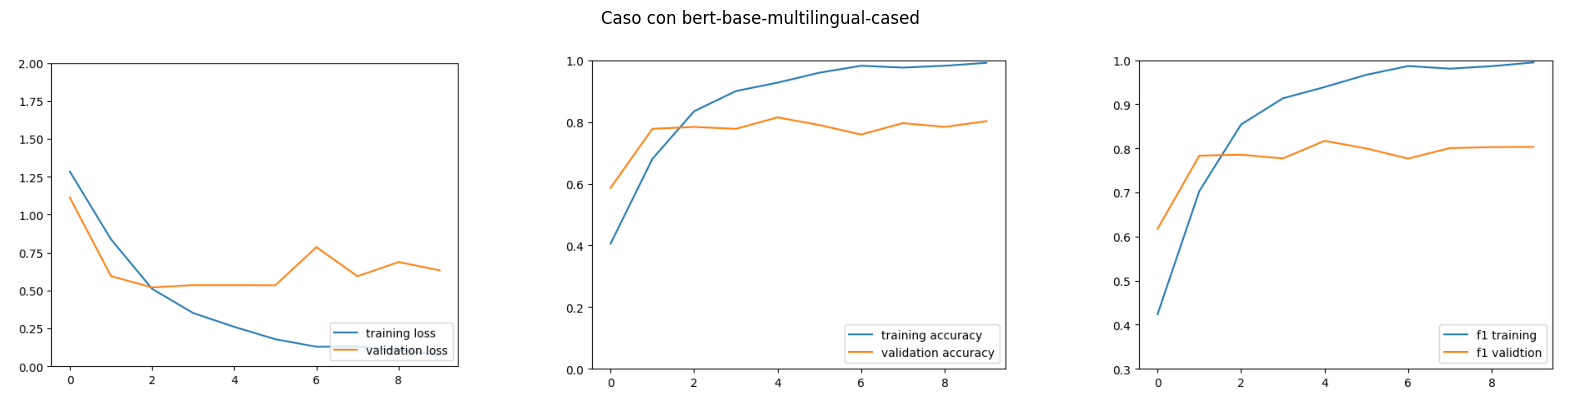

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


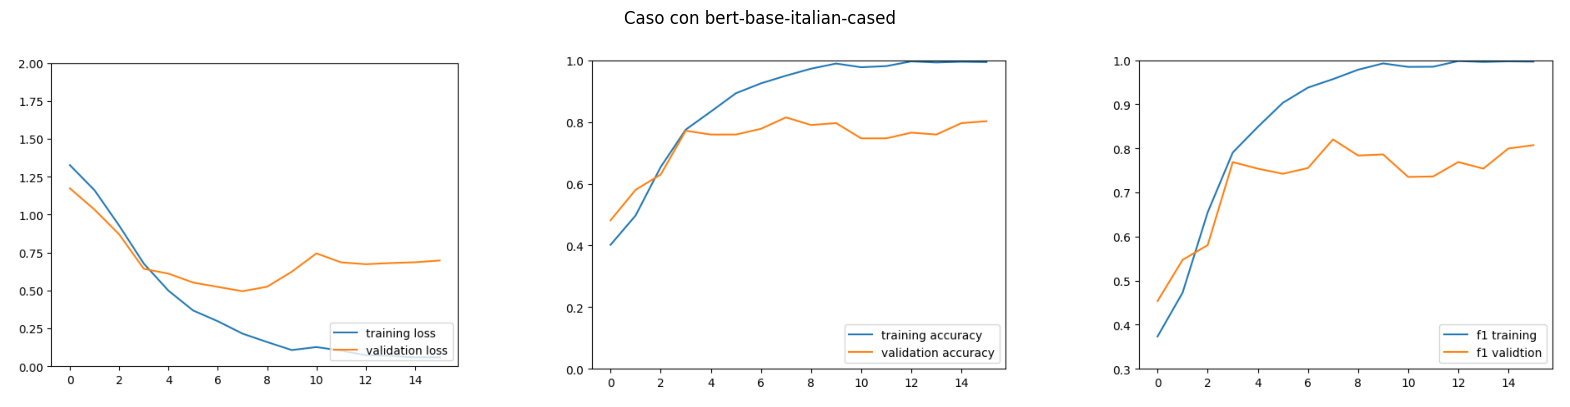

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
folder = '/content/gdrive/MyDrive/Tris di token/Translate Plot'

# Lista dei titoli delle sottocartelle
titoli_sottocartelle = ['xlm-roberta-base', 'bert-base-multilingual-cased', 'bert-base-italian-cased']

# Per ogni sottocartella
for titolo_sottocartella in titoli_sottocartelle:

    # Percorso completo della sottocartella
    percorso_sottocartella = os.path.join(folder, titolo_sottocartella)

    # Lista dei file nella sottocartella
    file_immagini = [f for f in os.listdir(percorso_sottocartella) if f.endswith('.png')]

    plt.figure(figsize=(20,6))

    for i, image in enumerate(file_immagini):

      img = mpimg.imread(os.path.join(percorso_sottocartella, image))

      plt.suptitle('Caso con ' + titolo_sottocartella, y=0.85)
      plt.subplot(1, 3, i+1)
      plt.imshow(img)

      plt.axis('off')

    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

Risultati dell'addestramento alla migliore epoca:

In [ ]:
translate_risultati=pd.read_csv(root+"translate_risultati.csv",delimiter=";")
translate_risultati

,Iperparametri,loss,accuracy,f1
0,xlm roberta bs: 8 lr:1e-5,0.4860,0.8086,0.8138
1,Bert Multilingua bs: 8 lr:1e-5,0.5202,0.7840,0.7858
2,Italian Bert bs: 8 lr:1e-5,0.4953,0.8148,0.8204


# Submission

Per effettuare le submissions abbiamo scelto inizialmente di provare la combinazione di iperparametri che ha performato meglio per ogni modello addestrato mediante il primo metodo di data augmentation ottenendo i seguenti risultati:

In [16]:
submission=pd.read_csv(root+"submissions_B_risultati.csv",delimiter=";")
submission

,Modello,Private Score,Public Score
0,Bert Multilingua bs: 8 lr:1e-5,0.77890,0.74310
1,Italian Bert bs:8 lr:1e-5,0.72874,0.72338
2,Roberta bs:8 lr:1e-5,0.85535,0.78079


Dai risultati ottenuti possiamo notare che il miglior modello è stato Roberta con batch size 8 e learning rate 1e-5, con un punteggio di 0.85535.
Abbiamo effettuato un ulteriore submission con Roberta non effettuando l'analisi delle emoji ottenendo però un risultato peggiore ovvero 0.74715 facendo notare l'importanza dall'analisi delle emoji in fase di preprocessing.

Successivamente abbiamo deciso di effettuare una submission per ogni modello addestrato con la seconda tecnica di data augmentation ottenendo i seguenti risultati:

In [17]:
submission_translate=pd.read_csv(root+"submissions_translate_risultati.csv",delimiter=";")
submission_translate

,Modello,Private Score,Public Score
0,Xlm Roberta bs:8 lr:1e-5,0.83707,0.74017
1,Bert Multilingua bs: 8 lr:1e-5,0.85893,0.78079
2,Italian Bert bs:8 lr:1e-5,0.87055,0.73543


Dai seguenti risultati possiamo notare che la seconda tecnica performa nettamente meglio, perchè i dati aggiunti sono più coerenti con il resto del dataset, mentre con la prima tecnica andiamo a inserire dati diversi che rendono il modello meno performante rispetto ai dati di test che dobbiamo classificare.

 Questa volta il modello che performa meglio è Italian Bert con un Private Score di 0.87055